In [0]:
# Mount on drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# All the libraries needed
import pandas as pd
import torch.optim as optim
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import shutil
import os
import gc
import csv
import ntpath
gc.collect()

0

In [0]:
prerna_path = '/content/gdrive/My Drive/APS360 Project'
sagar_path = '/content/gdrive/My Drive/APS360/APS360 Project'
neevi_path = '/content/gdrive/My Drive/3rd Year/APS360 Project'
project_path = prerna_path

In [0]:
#train_path = project_path + "/overfit/train"
train_path = project_path + "/overfit/train"
train_dataset = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))

valid_path = project_path + "/overfit/valid"
#valid_path = project_path + "/overfit/valid"
valid_dataset = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))

In [0]:
# Load image adoption speed
trainAdoptionSpeed = pd.read_csv(project_path+'/trainWithImageData1.csv', index_col=False)
testAdoptionSpeed = pd.read_csv(project_path+'/csvWithImageData/testWithImageData.csv', index_col=False)

In [0]:
def splitDataAndBalance(dataTable):
    trainingIndex = round(len(dataTable)*0.7)

    tDataset = dataTable[:trainingIndex]
    vDataset = dataTable[trainingIndex:]

    print(tDataset['AdoptionSpeed'].value_counts())
    print(vDataset['AdoptionSpeed'].value_counts())

    adoptionSpeedCounts = tDataset['AdoptionSpeed'].value_counts()
    
    maxIndex = adoptionSpeedCounts.idxmax()
    
    for index, count in adoptionSpeedCounts.iteritems():
        if index == maxIndex:
            continue;
        adoptionSpeedRows = tDataset[tDataset['AdoptionSpeed'] == index]
        adoptionSpeedDuplicateRows = adoptionSpeedRows.sample(adoptionSpeedCounts[maxIndex]-count, replace=True)
        tDataset = pd.concat([tDataset, adoptionSpeedDuplicateRows], axis=0)
    
    adoptionSpeedCounts = tDataset['AdoptionSpeed'].value_counts()

    tDataset = tDataset.values.astype(np.float32)
    vDataset = vDataset.values.astype(np.float32)
    
    return tDataset, vDataset    

In [0]:
train_valid_imgs_path = project_path + "/overfit/train"

delete_features = ["Name", "RescuerID", "VideoAmt", "Description", "PhotoAmt"]
pandaCSV = pd.read_csv(project_path+"/trainWithSent.csv", index_col=False)
originalTable = pandaCSV.drop(delete_features, axis=1)

originalTable = originalTable[['Type','Age','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize',
                              'FurLength','Vaccinated','Dewormed','Sterilized','Health','Quantity','Fee','State',
                              'SentimentScore','PetID','AdoptionSpeed']]

# Reduce the amount of data to the petIDs of image tensors
totalTensors = os.listdir(train_valid_imgs_path + "/0") + os.listdir(train_valid_imgs_path + "/1")

for index in range(len(totalTensors)):
  totalTensors[index] = totalTensors[index].split('.tensor')[0]

presentImages = pd.DataFrame(totalTensors)
presentImages.columns = ["PetID"]

mergedTable = pd.merge(originalTable, presentImages, how='inner', on=['PetID'])

originalTable = mergedTable.copy()
originalTable = originalTable.sample(frac=1).reset_index(drop=True)

originalTable['Vaccinated'] = originalTable['Vaccinated'].replace(3, 0)
originalTable['Dewormed'] = originalTable['Dewormed'].replace(3, 0)
originalTable['Sterilized'] = originalTable['Sterilized'].replace(3, 0)

# Normalize Table Values (Between 0 and 1)
minColumns = np.amin(originalTable, axis = 0)
maxColumns = np.amax(originalTable, axis = 0)

i = 0
for col in originalTable.columns: 
    if "AdoptionSpeed" in col or "PetID" in col or "SentimentScore" in col:
        continue
    originalTable[col] = np.where(originalTable[col] != np.nan, (originalTable[col] - minColumns[i])/(maxColumns[i] - minColumns[i]), np.nan)
    i += 1

# ANN No. 1 (Adoption Speeds should be 0 or 1)
ANNOneTable = originalTable.copy()
ANNOneTable.loc[ANNOneTable.index, 'PetID'] = ANNOneTable.index

ANNOneTable['AdoptionSpeed'] = np.where(ANNOneTable['AdoptionSpeed'] < 3, 0, 1)

train_ANNOne_dataset, valid_ANNOne_dataset = splitDataAndBalance(ANNOneTable)

0    355
1    345
Name: AdoptionSpeed, dtype: int64
1    155
0    145
Name: AdoptionSpeed, dtype: int64


In [0]:
originalTable[['Type','Age','Breed1','PetID']]

,Type,Age,Breed1,PetID
0,1.0,0.045455,0.866450,c67aca639
1,1.0,0.022727,0.866450,d0c81c563
2,0.0,0.007576,1.000000,d6691251b
3,0.0,0.007576,1.000000,caa616482
4,0.0,0.060606,1.000000,d3ffc5c1b
...,...,...,...,...
995,1.0,0.015152,0.866450,cd870fb18
996,1.0,0.015152,0.941368,d81a46211
997,0.0,0.090909,1.000000,c2490d2cf
998,1.0,0.007576,0.791531,c6c14a824


In [0]:
# Testing data
test_imgs_path = project_path + "/AlexNet/test/0"

petidcsv = pd.read_csv(project_path + "/test.csv")
petidcsv = petidcsv[["PetID"]]

pandaTestCSV = pd.read_csv(project_path + "/testwithsent.csv", index_col=False)

finalTableTest = pandaTestCSV.drop(delete_features+["AdoptionSpeed"], axis=1)
finalTableTest[["PetID"]] = petidcsv

totalTensors = os.listdir(test_imgs_path)

for index in range(len(totalTensors)):
  totalTensors[index] = totalTensors[index].split('.tensor')[0]

presentImages = pd.DataFrame(totalTensors)
presentImages.columns = ["PetID"]

mergedTable = pd.merge(finalTableTest, presentImages, how='inner', on=['PetID'])

finalTableTest = mergedTable.copy()

minColumns = np.amin(finalTableTest, axis = 0)
maxColumns = np.amax(finalTableTest, axis = 0)

i = 0
for col in finalTableTest.columns: 
    if "PetID" in col or "SentimentScore" in col:
        continue
    finalTableTest[col] = (finalTableTest[col] - minColumns[i])/(maxColumns[i] - minColumns[i])
    i += 1

kaggle_submission_table = finalTableTest[['PetID']].copy()
kaggle_submission_table['AdoptionSpeed'] = None    
    
finalTableTest.loc[finalTableTest.index, 'PetID'] = finalTableTest.index
    
test_dataset = finalTableTest.values.astype(np.float32)

In [0]:
torch.manual_seed(1) # set the random seed

# define a 5-layer artificial neural network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(18, 500)
        self.layer2 = nn.Linear(500, 200)
        self.layer3 = nn.Linear(200, 100)
        self.layer4 = nn.Linear(100, 50)
        self.layer5 = nn.Linear(50,2) #5
    def forward(self, label):
        activation1 = self.layer1(label)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        activation3 = F.relu(activation3)
        activation4 = self.layer4(activation3)
        activation4 = F.relu(activation4)
        activation5 = self.layer5(activation4)
        return activation5
    
class ANN_3layer(nn.Module):
    def __init__(self):
        super(ANN_3layer, self).__init__()
        self.layer1 = nn.Linear(18, 300)
        self.layer2 = nn.Linear(300, 150)
        self.layer3 = nn.Linear(150, 2)
    def forward(self, label):
        activation1 = self.layer1(label)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        return activation3

In [0]:
class pet_image(nn.Module):
    def __init__(self):
        super(pet_image, self).__init__()
        self.name = 'pet_image'
        self.layer1 = nn.Linear(9216, 5000)
        self.layer2 = nn.Linear(5000, 1000)
        self.layer3 = nn.Linear(1000, 200)
        self.layer4 = nn.Linear(200, 2)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, img):
        flattened = img.view(-1, 9216)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        # activation1 = self.dropout(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        # activation2 = self.dropout(activation2)
        activation3 = self.layer3(activation2)
        activation3 = F.relu(activation3)
        # activation3 = self.dropout(activation3)
        activation4 = self.layer4(activation3)
        return activation4

In [0]:
def plot_graphs(train_acc, train_loss = None, val_acc = None, val_loss = None):
    plt.title("Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    if not val_acc is None:
        plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

    if not train_loss is None:
        plt.title("Loss")
        n = len(train_acc) # number of epochs
        plt.plot(range(1,n+1), train_loss, label="Train")
        if not val_loss is None:
            plt.plot(range(1,n+1), val_loss, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()

def divideData(data):
    info, label = [], []
    for batchNo in data:
        i = 0
        info1, label1 = [], []
        for index in batchNo:
            if i <= 17:
                info1.append(index.item())
            else:
                label1.append(index.item())
            i += 1
        info.append(info1)
        label.append(label1)
    info = torch.tensor(info)
    label = torch.tensor(label)
    return info, label

def updateSubmissionTable(petIDIndex, pred):
    for ID, pred in zip(petIDIndex, pred):
        kaggle_submission_table.at[ID.item(), 'AdoptionSpeed'] = pred.item()

def normalizeLabels(label):
    maxVal = torch.max(label)
    minVal = torch.min(label)
    newLabel = (label - minVal) / (maxVal - minVal)
    
    return newLabel

def getAccuracy(model, model2, data_loader, lastIter):
    correct = 0
    total = 0
    for data in data_loader:
        # Divide the data from the data loader 
        # petData consists of the petIDIndex and the adoptionSpeed
        info, petData = divideData(data) 
        petIDIndex, label = petData.T

        # Normalized to be between 0 and 1
        label = normalizeLabels(label).T

        # Create a tensor of tensors by retrieving the tensors from Google Drive
        # (I got rid of the dictionary method as it is very inefficient)
        tensors = createTensorOfTensors(petData)

        # CSV ANN
        outputFromCSVANN = model(info)

        # Image ANN
        outputFromImageANN = model2(tensors)
        
        sf = F.softmax(outputFromCSVANN, dim = 1)
        sf2 = F.softmax(outputFromImageANN, dim = 1)
        combined = (sf + sf2)/2
        pred = combined.max(1, keepdim=True)[1]

        if lastIter:
            updateSubmissionTable(petIDIndex, sf)
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += data.shape[0]
    return correct/total

def validationTrain(model, model2, valid_loader, optimizerCSVANN, optimizerImageANN, criterion, lastIter):
    total_loss = 0
    iterations = 0
    for data in valid_loader:
        # Divide the data from the data loader 
        # petData consists of the petIDIndex and the adoptionSpeed
        info, petData = divideData(data) 
        petIDIndex, label = petData.T
        
        # Create a tensor of tensors by retrieving the tensors from Google Drive
        # (I got rid of the dictionary method as it is very inefficient)
        tensors = createTensorOfTensors(petData)

        # CSV ANN
        outputFromCSVANN = model(info)

        lossCSVANN = criterion(outputFromCSVANN, label.long())

        # Image ANN
        outputFromImageANN = model2(tensors)
        lossImageANN = criterion(outputFromImageANN, label.long())
        
        totalANNLoss = lossCSVANN + lossImageANN

        total_loss += totalANNLoss
        
        optimizerCSVANN.zero_grad()

        optimizerImageANN.zero_grad()

        iterations += 1
    return getAccuracy(model, model2, valid_loader, lastIter), float(total_loss) / iterations

def createTensorOfTensors(petIDIndex, testTensors=False):
  listOfTensors = []

  if testTensors:
    for petID in petIDIndex:
      alphaNumericPetID = mergedTable[mergedTable.index == petID.item()].PetID.values[0]
      petImageTensor = torch.load(test_imgs_path + '/' + alphaNumericPetID + '.tensor')
      listOfTensors.append(petImageTensor)
  else:
    for petID, adoptionSpeed in petIDIndex:
      alphaNumericPetID = originalTable[originalTable.index == petID.item()].PetID.values[0]
      petImageTensor = torch.load(train_valid_imgs_path + '/' + str(round(adoptionSpeed.item())) + '/' + alphaNumericPetID + '.tensor')
      listOfTensors.append(petImageTensor)

  bigTensor = torch.stack(listOfTensors, dim=0)
  return bigTensor

def train(model, model2, num_epochs=5, batch_size=64, learning_rate=1e-4):
    torch.manual_seed(1)
    criterion = nn.CrossEntropyLoss()
    optimizerCSVANN = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizerImageANN = torch.optim.Adam(model2.parameters(), lr=learning_rate)

    train_acc, train_loss, valid_acc, valid_loss = [], [], [], []

    for epoch in range(num_epochs):
        total_loss = 0;
        iterations = 0;

        loader_train = torch.utils.data.DataLoader(train_ANNOne_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
        loader_val = torch.utils.data.DataLoader(valid_ANNOne_dataset, batch_size=batch_size, num_workers=0, shuffle=True)

        for data in loader_train:
            # Divide the data from the data loader 
            # petData consists of the petIDIndex and the adoptionSpeed
            info, petData = divideData(data) 
            petIDIndex, label = petData.T

            # Create a tensor of tensors by retrieving the tensors from Google Drive
            # (I got rid of the dictionary method as it is very inefficient)
            tensors = createTensorOfTensors(petData)

            # CSV ANN
            outputFromCSVANN = model(info)
            lossCSVANN = criterion(outputFromCSVANN, label.long())

            # Image ANN
            outputFromImageANN = model2(tensors)
            lossImageANN = criterion(outputFromImageANN, label.long())
            
            totalANNLoss = lossCSVANN + lossImageANN
            totalANNLoss.backward()

            total_loss += totalANNLoss
            
            optimizerCSVANN.step()
            optimizerCSVANN.zero_grad()

            optimizerImageANN.step()
            optimizerImageANN.zero_grad()

            iterations += 1
        train_acc.append(getAccuracy(model, model2, loader_train, False)) #Epoch = (num_epochs - 1)
        train_loss.append(float(total_loss) /iterations)
        print("Training Accuracy: " + str(round(train_acc[-1]*100,2)) + "%", "Current epoch: ", epoch)
        
        v_acc, v_loss = validationTrain(model, model2, loader_val, optimizerCSVANN, optimizerImageANN, criterion, False) #Epoch = (num_epochs - 1)
        valid_acc.append(v_acc)
        valid_loss.append(v_loss)
        print("Validation Accuracy: "+ str(round(valid_acc[-1]*100,2)) + "%", "Current epoch: ", epoch)

    plot_graphs(train_acc, train_loss, valid_acc, valid_loss)
    
def runTest(model, model2, batch_size=64):
    kaggle_submission_table.loc[:, 'AdoptionSpeed'] = None  
    
    loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
    
    iterations = 0
    for data in loader_test:
        print("Batch", iterations, "out of", round(len(test_dataset)/batch_size))
        info, petIDIndex = divideData(data)

        tensors = createTensorOfTensors(petIDIndex, True)
        
        outputFromCSVANN = model(info)
        outputFromImageANN = model2(tensors)

        sf = F.softmax(outputFromCSVANN, dim = 1)
        sf2 = F.softmax(outputFromImageANN, dim = 1)
        combined = (sf + sf2)/2
        pred = combined.max(1, keepdim=True)[1]

        updateSubmissionTable(petIDIndex.squeeze(1), pred.squeeze(1))
        iterations += 1


Training Accuracy: 50.0% Current epoch:  0
Validation Accuracy: 48.33% Current epoch:  0
Training Accuracy: 57.04% Current epoch:  1
Validation Accuracy: 55.33% Current epoch:  1
Training Accuracy: 69.58% Current epoch:  2
Validation Accuracy: 59.0% Current epoch:  2
Training Accuracy: 69.86% Current epoch:  3
Validation Accuracy: 57.0% Current epoch:  3
Training Accuracy: 78.59% Current epoch:  4
Validation Accuracy: 57.33% Current epoch:  4
Training Accuracy: 86.34% Current epoch:  5
Validation Accuracy: 60.33% Current epoch:  5
Training Accuracy: 80.85% Current epoch:  6
Validation Accuracy: 56.67% Current epoch:  6
Training Accuracy: 91.69% Current epoch:  7
Validation Accuracy: 60.67% Current epoch:  7
Training Accuracy: 94.08% Current epoch:  8
Validation Accuracy: 61.33% Current epoch:  8
Training Accuracy: 97.32% Current epoch:  9
Validation Accuracy: 60.0% Current epoch:  9
Training Accuracy: 97.75% Current epoch:  10
Validation Accuracy: 58.67% Current epoch:  10
Training Acc

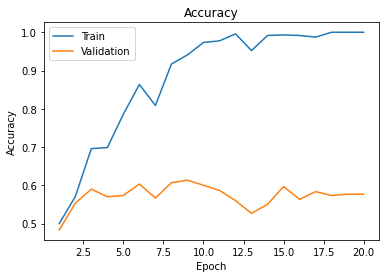

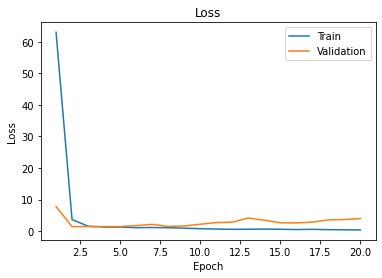

In [0]:
ANN_net = ANN()
pet_image_net = pet_image()
# output, recon, recon_total, information = train(model=ANN_net, batch_size=300, num_epochs=35, learning_rate=0.005)
train(model=ANN_net, model2=pet_image_net, batch_size=200, num_epochs=20, learning_rate=0.005)
# BS = 30, learning rate = 1e-5
#0.007 better, 0.003 worked better than 0.001
# BS = 300, learning rate = 0.005, num_epochs=35
# March 27 - Best BS = 200, Learning Rate = 0.005 and Num Epochs = 35

In [0]:
runTest(model=ANN_net, model2=pet_image_net, batch_size=200)

Batch 0 out of 18
Batch 1 out of 18
Batch 2 out of 18
Batch 3 out of 18
Batch 4 out of 18
Batch 5 out of 18
Batch 6 out of 18
Batch 7 out of 18
Batch 8 out of 18
Batch 9 out of 18
Batch 10 out of 18
Batch 11 out of 18
Batch 12 out of 18
Batch 13 out of 18
Batch 14 out of 18
Batch 15 out of 18
Batch 16 out of 18
Batch 17 out of 18


In [0]:
# Load Winning Team's csv
winningTeamCSV = pd.read_csv(project_path + "/winning_team.csv", index_col=False)
for index, row in winningTeamCSV.iterrows():
    if row.AdoptionSpeed >= 3:
        winningTeamCSV.loc[index, 'AdoptionSpeed'] = 1
    else:
        winningTeamCSV.loc[index, 'AdoptionSpeed'] = 0

winningTestCSV1 = pd.merge(winningTeamCSV, kaggle_submission_table, how='inner', on=['PetID'])
winningTestCSV1 = winningTestCSV1.drop(['AdoptionSpeed_y'], axis=1)
winningTestCSV1.columns = ['PetID', 'AdoptionSpeed']
winningTeamCSV = winningTestCSV1.copy()

In [0]:
results = np.where(winningTeamCSV['AdoptionSpeed'] == kaggle_submission_table['AdoptionSpeed'], True, False)
totalCorrect = results.sum()

In [0]:
print(round(totalCorrect/len(winningTeamCSV) * 100,2), "%")

58.63 %
